# Capstone Project: Who will be the next super unicorn?

This project aims to predict which unicorn startups (defined as companies with a billion dollar or higher valuation) will continue to grow to be a super unicorn company. A super unicorn is the top 25% unicorns in size: the cutoff is $3bn based on the current dataset). 

I use a free unicorn dataset from Kaggle (courtesy of Ram Maurya). Link: https://www.kaggle.com/datasets/ramjasmaurya/unicorn-startups

I like the inclusiveness of this dataset (includes all the unicorns around the world). However, it does lack many important features that are useful in predicting future valuation of a company (e.g. company performance metrics, seed investors etc). As such, this is just a toy modeling exercise and I would strongly urge people to view these results with a grain of salt.

In the below analysis, I have trained and cross-validated four machine learning models: logistic regressions (L1 and L2 penality), random forest classifier, and gradient boosting classifier. Based on the holder score from the training set and the AUROC score from the test set, I have chosen the **Gradient Boosting Classifier** to be the winning model.


# Import Libraries

In [271]:
# import Python Packages

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

# import machine learning modules

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier


# import pipeline and scalers

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# import model selection modules

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Date Cleaning and Exploratory Analysis

In [272]:
df = pd.read_csv('/Users/Desktop/Elite Data Science/Capstone/unicorns till sep 2022.csv')

## Basic Information

In [273]:
df.head()

,Company,Valuation ($B),Date Joined,Country,City,Industry,Investors
0,ByteDance,$140,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,$127,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,$100,7/3/2018,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,$95,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG"
4,Canva,$40,1/8/2018,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat..."


In [274]:
# how many observations
print(df.shape)

# how many features
df.dtypes



(1186, 7)


Company           object
Valuation ($B)    object
Date Joined       object
Country           object
City              object
Industry          object
Investors         object
dtype: object

In [275]:
# change 'City' to 'Industry'

# df.City

Woops! It seems 'City' is not the right column name. Let's investigate:

In [276]:
# for i in df.dtypes.index:
    #print(i, len(i))

So it seems the 4-letter word actually has a length of 5.

Let's rename all columns to be safe:

In [277]:
df.columns = ['Company', 'Valuation', 'Date_Joined', 'Country', 'City', 'Industry', 'Investors']

df.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors
0,ByteDance,$140,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,$127,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,$100,7/3/2018,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,$95,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG"
4,Canva,$40,1/8/2018,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat..."


## Reformat
#### Reformat'Valuation ($B)' into float

In [278]:
# format 'Valuation' as a float
df.Valuation = df.Valuation.str.replace('$', '', regex=False).astype(float)

df.head()


,Company,Valuation,Date_Joined,Country,City,Industry,Investors
0,ByteDance,140.0,4/7/2017,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S..."
1,SpaceX,127.0,12/1/2012,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
2,SHEIN,100.0,7/3/2018,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China..."
3,Stripe,95.0,1/23/2014,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG"
4,Canva,40.0,1/8/2018,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat..."


#### Reformat Date_Joined to date

In [279]:
df['Date_Joined'] = pd.to_datetime(df.Date_Joined)

In [280]:
df.dtypes

Company                object
Valuation             float64
Date_Joined    datetime64[ns]
Country                object
City                   object
Industry               object
Investors              object
dtype: object

#### Calculate Age

In [281]:
from datetime import datetime

today = datetime.today()

df['age'] = (today - df.Date_Joined).dt.days

df.age.head()

0    1998
1    3586
2    1546
3    3168
4    1722
Name: age, dtype: int64

## Check for missing data

In [282]:
df.isnull().sum()

Company         0
Valuation       0
Date_Joined     0
Country         0
City            0
Industry        0
Investors      18
age             0
dtype: int64

In [283]:
df[df.Investors.isnull()]

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age
10,FTX,32.00,2021-07-20,Bahamas,Fintech,"Sequoia Capital, Thoma Bravo, Softbank",NaN,433
242,HyalRoute,3.50,2020-05-26,Singapore,Mobile & telecommunications,Kuang-Chi,NaN,853
316,Amber Group,3.00,2021-06-21,Hong Kong,Fintech,"Tiger Global Management, Tiger Brokers, DCM Ve...",NaN,462
346,Moglix,2.60,2021-05-17,Singapore,E-commerce & direct-to-consumer,"Jungle Ventures, Accel, Venture Highway",NaN,497
371,Coda Payments,2.50,2022-04-15,Singapore,Fintech,"GIC. Apis Partners, Insight Partners",NaN,164
482,Advance Intelligence Group,2.00,2021-09-23,Singapore,Artificial intelligence,"Vision Plus Capital, GSR Ventures, ZhenFund",NaN,368
495,Trax,2.00,2019-07-22,Singapore,Artificial intelligence,"Hopu Investment Management, Boyu Capital, DC T...",NaN,1162
865,Carousell,1.10,2021-09-15,Singapore,E-commerce & direct-to-consumer,"500 Global, Rakuten Ventures, Golden Gate Vent...",NaN,376
917,LinkSure Network,1.00,2015-01-01,China,Shanghai,Mobile & telecommunications,NaN,2825
941,WeLab,1.00,2017-11-08,Hong Kong,Fintech,"Sequoia Capital China, ING, Alibaba Entreprene...",NaN,1783


## Fix the above 18 observations:
#### 1. "City" should have been "Industry" 
#### 2. "Industry" should have been "Investors"
#### 3. "City" is the same as "Country"
#### 4. Delete obs #917 as it is missing 'Investors'

In [284]:
# make a copy of df
df2 = df[df.Investors.isnull()].copy()

# change 'Industry' to 'Investors', 'City' to 'Industry', 'Country' to 'City'
df2.Investors = df2.Industry
df2.Industry = df2.City
df2.City = df2.Country

# Merge df with df2 using .combine_first
df3 = df2.combine_first(df)

# check to make sure these datapoints are cleaned correctly
df3.iloc[df2.index]




,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age
10,FTX,32.00,2021-07-20,Bahamas,Bahamas,Fintech,"Sequoia Capital, Thoma Bravo, Softbank",433.0
242,HyalRoute,3.50,2020-05-26,Singapore,Singapore,Mobile & telecommunications,Kuang-Chi,853.0
316,Amber Group,3.00,2021-06-21,Hong Kong,Hong Kong,Fintech,"Tiger Global Management, Tiger Brokers, DCM Ve...",462.0
346,Moglix,2.60,2021-05-17,Singapore,Singapore,E-commerce & direct-to-consumer,"Jungle Ventures, Accel, Venture Highway",497.0
371,Coda Payments,2.50,2022-04-15,Singapore,Singapore,Fintech,"GIC. Apis Partners, Insight Partners",164.0
482,Advance Intelligence Group,2.00,2021-09-23,Singapore,Singapore,Artificial intelligence,"Vision Plus Capital, GSR Ventures, ZhenFund",368.0
495,Trax,2.00,2019-07-22,Singapore,Singapore,Artificial intelligence,"Hopu Investment Management, Boyu Capital, DC T...",1162.0
865,Carousell,1.10,2021-09-15,Singapore,Singapore,E-commerce & direct-to-consumer,"500 Global, Rakuten Ventures, Golden Gate Vent...",376.0
917,LinkSure Network,1.00,2015-01-01,China,China,Shanghai,Mobile & telecommunications,2825.0
941,WeLab,1.00,2017-11-08,Hong Kong,Hong Kong,Fintech,"Sequoia Capital China, ING, Alibaba Entreprene...",1783.0


In [285]:
# delete #917
df3.drop(917, inplace=True)


## Separate "Investors" into different columns

In [286]:
# Separate Investors: Investor1, Investor2, Investor3, Investor4

df3[['Investor1', 'Investor2', 'Investor3', 'Investor4']] = df3.Investors.str.split(', ', expand=True)

df3.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4
0,ByteDance,140.0,2017-04-07,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,None
2,SHEIN,100.0,2018-07-03,China,Shenzhen,E-commerce & direct-to-consumer,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,None
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,None
4,Canva,40.0,2018-01-08,Australia,Surry Hills,Internet software & services,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,None


In [287]:
for column in ['Investor1', 'Investor2', 'Investor3', 'Investor4']:
    df3[column].str.strip(' ')

## Count Plots

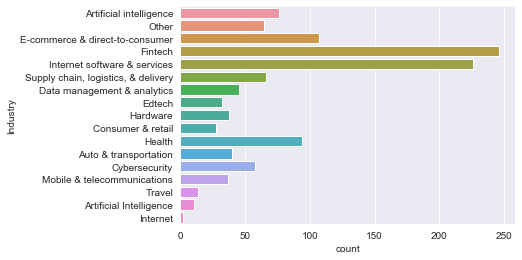

In [288]:
df = df3

# drop duplicates
df.drop_duplicates()

# count plot for Industry, Country, City, Date Joined, Investor
sns.countplot(y='Industry', data=df)
plt.show()


## Clean up Industry names

* Shorten names
* Regroup
* Combine the smallest groups into "Other"

In [289]:
list(df.Industry.unique())

['Artificial intelligence',
 'Other',
 'E-commerce & direct-to-consumer',
 'Fintech',
 'Internet software & services',
 'Supply chain, logistics, & delivery',
 'Data management & analytics',
 'Edtech',
 'Hardware',
 'Consumer & retail',
 'Health',
 'Auto & transportation',
 'Cybersecurity',
 'Mobile & telecommunications',
 'Travel',
 'Artificial Intelligence',
 'Internet']

In [290]:
df.Industry.replace(['Artificial intelligence', 'Artificial Intelligence'], 'AI', inplace=True)
df.Industry.replace('E-commerce & direct-to-consumer', 'Ecomm', inplace=True)
df.Industry.replace(['Internet software & services', 'Internet'], 'IT', inplace=True)
df.Industry.replace('Supply chain, logistics, & delivery', 'Schain', inplace=True)
df.Industry.replace('Data management & analytics', 'Data', inplace=True)
df.Industry.replace('Consumer & retail', 'Consumer', inplace=True)
df.Industry.replace('Auto & transportation', 'Auto', inplace=True)
df.Industry.replace('Mobile & telecommunications', 'Telcom', inplace=True)


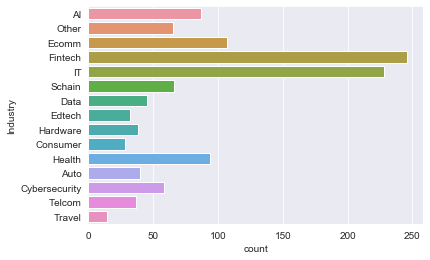

In [291]:
sns.countplot(y=df.Industry)

In [292]:

# country list
print(df.Country.value_counts())

# city list
print(df.City.value_counts())

United States           636
China                   173
India                    70
United Kingdom           46
Germany                  29
France                   24
Israel                   22
Canada                   19
South Korea              17
Brazil                   17
Singapore                13
Australia                 8
Sweden                    8
Mexico                    8
Indonesia                 7
Hong Kong                 7
Netherlands               7
Switzerland               6
Japan                     6
Ireland                   6
Norway                    5
Spain                     4
Finland                   4
United Arab Emirates      3
Belgium                   3
Colombia                  3
Turkey                    3
Chile                     2
Austria                   2
Croatia                   2
Vietnam                   2
Lithuania                 2
South Africa              2
Denmark                   2
Thailand                  2
Philippines         

## Regroup Country: Region



In [293]:
def categorize(x):
    if x['Country'] in ['Sweden', 'Norway', 'Finland', 'Denmark']:
        return 'Scandi'
    elif x['Country'] in ['Netherlands', 'Switzerland', 'Ireland', 'Spain', 'Belgium', 'Italy', 'Luxembourg', 'Austria']:
        return 'Other_Europe'
    elif x['Country'] in ['Croatia','Czech Republic', 'Lithuania', 'Estonia']:
        return 'East_Europe'
    elif x['Country'] in ['Turkey', 'United Arab Emirates'] :
        return 'MidEast'
    elif x['Country'] in ['Mexico', 'Columbia', 'Argentina', 'Chile', 'Ecuador']:
        return 'S_America'
    elif x['Country'] in ['Indonesia', 'Hong Kong', 'Vietnam', 'Philippines', 'Thailand', 'Malaysia']:
        return 'Other_Asia'
    elif x['Country'] in ['South Africa', 'Senegal', 'Nigeria', 'Seychelles']:
        return 'Africa'
    elif x['Country'] in ['Bahamas', 'Bermuda', ]:
        return 'Other_region'
    else:
        return x['Country']
    
    
df['Region'] = df.apply(lambda x: categorize(x), axis=1)

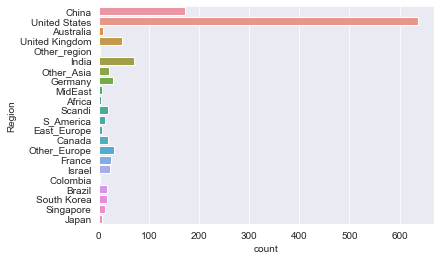

In [294]:
sns.countplot(data=df, y='Region')
plt.show()

## Clean up Investors

In [295]:
df.dtypes

Company                object
Valuation             float64
Date_Joined    datetime64[ns]
Country                object
City                   object
Industry               object
Investors              object
age                   float64
Investor1              object
Investor2              object
Investor3              object
Investor4              object
Region                 object
dtype: object

In [296]:
df.shape

(1185, 13)

In [297]:
# Investor1
df.Investor1.replace('Accel Partners', 'Accel', inplace=True)
df.Investor1.replace('Goldman Sachs Asset Management', 'Goldman Sachs', inplace=True)
df.Investor1.replace('Tencent Holdings', 'Tencent', inplace=True)

In [298]:
df.Investor1.value_counts().head(20)

Accel                               34
Andreessen Horowitz                 33
Sequoia Capital China               30
Insight Partners                    24
Sequoia Capital                     20
New Enterprise Associates           18
Tencent                             16
Tiger Global Management             15
Index Ventures                      14
Lightspeed Venture Partners         14
Bessemer Venture Partners           13
SoftBank Group                      13
General Catalyst                    13
Sequoia Capital India               12
Khosla Ventures                     11
General Atlantic                    11
IDG Capital                          9
GGV Capital                          9
Kleiner Perkins Caufield & Byers     9
Goldman Sachs                        8
Name: Investor1, dtype: int64

In [299]:
# Investor2

# df.Investor2.value_counts().head(60)

In [300]:
# Investor3

df.Investor3.value_counts().head(60)
df.Investor3.replace('GS Growth', 'Goldman Sachs', inplace=True)
df.Investor3.replace('Tencent Holdings', 'Tencent', inplace=True)

# Feature Engineering

#### Create Target Variable: Super unicorn dummy

In [301]:
# the top 25% valuation cutoff: 3

df.Valuation.sort_values().tail(297)


316      3.0
310      3.0
309      3.0
308      3.0
307      3.0
       ...  
4       40.0
3       95.0
2      100.0
1      127.0
0      140.0
Name: Valuation, Length: 297, dtype: float64

In [302]:
# define 'super' to be bigger than $3bn in valuation
df['super']=(df.Valuation >= 3).astype(int)

In [303]:
df.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super
0,ByteDance,140.0,2017-04-07,China,Beijing,AI,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group,China,1
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,None,United States,1
2,SHEIN,100.0,2018-07-03,China,Shenzhen,Ecomm,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,None,China,1
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,None,United States,1
4,Canva,40.0,2018-01-08,Australia,Surry Hills,IT,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,None,Australia,1


#### Create Region Dummies

In [304]:
region_dummies = pd.get_dummies(df.Region)
region_dummies['Company'] = df.Company
region_dummies.head()

,Africa,Australia,Brazil,Canada,China,Colombia,East_Europe,France,Germany,India,Israel,Japan,MidEast,Other_Asia,Other_Europe,Other_region,S_America,Scandi,Singapore,South Korea,United Kingdom,United States,Company
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ByteDance
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,SpaceX
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,SHEIN
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Stripe
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Canva


#### Create Industry Dummies

In [305]:
industry_dummies = pd.get_dummies(df.Industry)
industry_dummies['Company'] = df.Company

#### Create two features based on the lead investor (Investor1):

* "deals": The total number of unicorns in this investors portfolio as lead investor
* "top_investor": a dummy variable if Investor1 is among the top 10 investors (defined as having more than 14 unicorns in their portfolio companies)

In [306]:
# Lead Investor: number of unicorn companies each Investor1 has in their portfolio
lead_investor_deals = df.Investor1.value_counts().to_frame(name = 'deals')

# merge with df
df = df.merge(
    lead_investor_deals,
    how ='left',
    left_on = 'Investor1',
    right_index=True)

df['top_investor'] = (df.deals >=14).astype(int)

# Investor2
# df.Investor2.str.strip()
# second_investor = pd.get_dummies(df.Investor2)
# second_investor['Company'] = df.Company

# Investor3
#third_investor = pd.get_dummies(df.Investor3)
#third_investor['Company'] = df.Company

# Investor4
#fourth_investor = pd.get_dummies(df.Investor4)
#fourth_investor['Company'] = df.Company

In [307]:
df.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,top_investor
0,ByteDance,140.0,2017-04-07,China,Beijing,AI,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group,China,1,30,1
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,None,United States,1,5,0
2,SHEIN,100.0,2018-07-03,China,Shenzhen,Ecomm,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,None,China,1,15,1
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,None,United States,1,11,0
4,Canva,40.0,2018-01-08,Australia,Surry Hills,IT,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,None,Australia,1,30,1


## Analytical Base Table (ABT)


We will select the following features
* Age
* Industry
* Region
* Lead investor: whether it is a top investor and the number of deals it has done

In [308]:
df = df.merge(industry_dummies, 
                how = 'left',
                 left_on ='Company',
                 right_on ='Company')

df2 = df.merge(region_dummies,
               how ='left',
              left_on = 'Company',
              right_on = 'Company')

df2['log_age'] = np.log(df2.age)
df2['log_deals'] = np.log(df2.deals)

# save as csv file
df2.to_csv('/Users/Desktop/Elite Data Science/Capstone/abt_unicorn.csv', index=None)

In [309]:
df2.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,top_investor,AI,Auto,Consumer,Cybersecurity,Data,Ecomm,Edtech,Fintech,Hardware,Health,IT,Other,Schain,Telcom,Travel,Africa,Australia,Brazil,Canada,China,Colombia,East_Europe,France,Germany,India,Israel,Japan,MidEast,Other_Asia,Other_Europe,Other_region,S_America,Scandi,Singapore,South Korea,United Kingdom,United States,log_age,log_deals
0,ByteDance,140.0,2017-04-07,China,Beijing,AI,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group,China,1,30,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.599902,3.401197
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,None,United States,1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.184793,1.609438
2,SHEIN,100.0,2018-07-03,China,Shenzhen,Ecomm,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,None,China,1,15,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.343426,2.708050
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,None,United States,1,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.060856,2.397895
4,Canva,40.0,2018-01-08,Australia,Surry Hills,IT,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,None,Australia,1,30,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.451242,3.401197


# Algorithm Selection

We will compare the following machine learning models

* Logistic Regression (L1 & L2 types: 'l1', 'l2')
* Random Forest: 'rf'
* Gradient Boosting: 'gb'

## Dataset Prepration 

In [310]:
# read ABT

df = pd.read_csv('/Users/Desktop/Elite Data Science/Capstone/abt_unicorn.csv')
df.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,top_investor,AI,Auto,Consumer,Cybersecurity,Data,Ecomm,Edtech,Fintech,Hardware,Health,IT,Other,Schain,Telcom,Travel,Africa,Australia,Brazil,Canada,China,Colombia,East_Europe,France,Germany,India,Israel,Japan,MidEast,Other_Asia,Other_Europe,Other_region,S_America,Scandi,Singapore,South Korea,United Kingdom,United States,log_age,log_deals
0,ByteDance,140.0,2017-04-07,China,Beijing,AI,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group,China,1,30,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.599902,3.401197
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,NaN,United States,1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.184793,1.609438
2,SHEIN,100.0,2018-07-03,China,Shenzhen,Ecomm,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,NaN,China,1,15,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.343426,2.708050
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,NaN,United States,1,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.060856,2.397895
4,Canva,40.0,2018-01-08,Australia,Surry Hills,IT,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,NaN,Australia,1,30,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.451242,3.401197


#### Target variable: 'super'

#### Features: 
        * log(age)
        * log(deals)
        * Region dummies
        * Industry dummies
        * Top_investor

In [311]:
# Create separate object for target variable and features
# target variable
y = df.super

# features
X = df.drop(['Company', 'Date_Joined','Valuation', 'Country', 'City', 'Industry', 
             'Investors', 'age', 'Investor1', 'Investor2', 'Investor3',
             'Investor4', 'Region', 'super', 'deals'], axis=1)

X.head()

,top_investor,AI,Auto,Consumer,Cybersecurity,Data,Ecomm,Edtech,Fintech,Hardware,Health,IT,Other,Schain,Telcom,Travel,Africa,Australia,Brazil,Canada,China,Colombia,East_Europe,France,Germany,India,Israel,Japan,MidEast,Other_Asia,Other_Europe,Other_region,S_America,Scandi,Singapore,South Korea,United Kingdom,United States,log_age,log_deals
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.599902,3.401197
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.184793,1.609438
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.343426,2.708050
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.060856,2.397895
4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.451242,3.401197


In [312]:
# Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   stratify=df.Region)

print(len(X_train), len(X_test), len(y_train), len(y_test))

962 241 962 241


## Model Training

#### Create pipeline dictionary

In [313]:
# create a pipeline dictionary for the four candidate algorithms

pipelines = {'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1')),
             'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2')),
             'rf': make_pipeline(StandardScaler(), RandomForestClassifier()),
             'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier())}

In [314]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradientboosting#sklearn.ensemble.GradientBoostingClassifier

#### Create hyperparameter dictionary

In [315]:
# use get_params() to get a list of hyperparameters for each algorithm
# l1:
pipelines['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression(penalty='l1'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(penalty='l1'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [316]:
# note l1 and l2 have the same tunable hyperparams as they are both logistic classifiers

l1_hyperparams = {'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
                  'logisticregression__solver': ['liblinear']}
l2_hyperparams = {'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
                  'logisticregression__solver': ['lbfgs', 'liblinear']}


In [317]:
# rf:
pipelines['rf'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 

In [318]:
# rf hyperparameters

rf_hyperparams = {
    'randomforestclassifier__max_features': ['sqrt', 'auto', 'log2', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10],
    'randomforestclassifier__n_estimators': [100, 200]
}

In [319]:
# gb:
pipelines['gb'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('gradientboostingclassifier', GradientBoostingClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'gradientboostingclassifier': GradientBoostingClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__max_leaf_nodes': None,
 'gradientboostingclassifier__min_impurity_decrease': 0.0,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__min_weight_fraction_leaf': 0.0,
 'gradientboostingclassifie

In [320]:
# gb hyperparameters

gb_hyperparams = {
    'gradientboostingclassifier__max_features': ['auto', 'sqrt', 'log2' ],
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [321]:
# hyperparameters dictionary

hyperparameters = {
    'l1': l1_hyperparams,
    'l2': l2_hyperparams,
    'rf': rf_hyperparams,
    'gb': gb_hyperparams
}

#### Cross Validation

In [322]:
## write for loop to tune hyperparameters

fitted_models = {}

for algorithm in pipelines.keys():
    
    model = GridSearchCV( 
        pipelines[algorithm],
        hyperparameters[algorithm],
        cv=10,
        n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    fitted_models[algorithm] = model
    print('Model {}'.format(algorithm), ' has been fitted.')

Model l1  has been fitted.
Model l2  has been fitted.
Model rf  has been fitted.
Model gb  has been fitted.


In [323]:
## compare the holdout scores:

for name, model in fitted_models.items():
    print ('The holdout score for model {} is '.format(name), model.best_score_)

The holdout score for model l1 is  0.7411404639175259
The holdout score for model l2 is  0.7411404639175256
The holdout score for model rf is  0.7474441580756014
The holdout score for model gb is  0.7525665807560137


So based on the training data, Random Forest Classifier has the best holdout accuracy (highest holdout score).

#### Model Evaluation (using test set)

Now apply the best configuration from each algorithm to the test set.

In [324]:
from sklearn.metrics import roc_auc_score

for name, model in fitted_models.items():
    pred = fitted_models[name].predict_proba(X_test)[:,1]
    
    score = roc_auc_score(y_test, pred)
    print ('AUROC score for model {} is '.format(name), score)

AUROC score for model l1 is  0.7556238873604142
AUROC score for model l2 is  0.7532772293251336
AUROC score for model rf is  0.811296326266386
AUROC score for model gb is  0.7890839941738145


Based on the holdout score and the AUROC score from the test set, I choose the **Gradient Boosting Classifier** as the winning model.

In [325]:
type(fitted_models['gb'])

sklearn.model_selection._search.GridSearchCV

In [327]:
# save the winning model

import pickle

with open('final_model_unicorn.pkl', 'wb') as f:
      pickle.dump(fitted_models['gb'].best_estimator_, f)
    

## Make Predictions on the original data

In [328]:
# Apply the winning prediciton model to the whole dataset

data = pd.read_csv('/Users/Desktop/Elite Data Science/Capstone/abt_unicorn.csv')

# target variable
y = data.super

# features
X = data.drop(['Company', 'Date_Joined','Valuation', 'Country', 'City', 'Industry', 
             'Investors', 'age', 'Investor1', 'Investor2', 'Investor3',
             'Investor4', 'Region', 'super', 'deals'], axis=1)

# predicted probabilities
pred_proba = fitted_models['gb'].predict_proba(X)[:, 1]

# predicitons
pred = fitted_models['gb'].predict(X)


In [329]:
data.head()

,Company,Valuation,Date_Joined,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,top_investor,AI,Auto,Consumer,Cybersecurity,Data,Ecomm,Edtech,Fintech,Hardware,Health,IT,Other,Schain,Telcom,Travel,Africa,Australia,Brazil,Canada,China,Colombia,East_Europe,France,Germany,India,Israel,Japan,MidEast,Other_Asia,Other_Europe,Other_region,S_America,Scandi,Singapore,South Korea,United Kingdom,United States,log_age,log_deals
0,ByteDance,140.0,2017-04-07,China,Beijing,AI,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group,China,1,30,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.599902,3.401197
1,SpaceX,127.0,2012-12-01,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,NaN,United States,1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.184793,1.609438
2,SHEIN,100.0,2018-07-03,China,Shenzhen,Ecomm,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,NaN,China,1,15,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.343426,2.708050
3,Stripe,95.0,2014-01-23,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,NaN,United States,1,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8.060856,2.397895
4,Canva,40.0,2018-01-08,Australia,Surry Hills,IT,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,NaN,Australia,1,30,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.451242,3.401197


In [330]:
# combine with pred and pred_proba

# drop engineered features in "data"
df = data.copy()[['Company', 'Date_Joined','Valuation', 'Country', 'City', 'Industry', 
             'Investors', 'age', 'Investor1', 'Investor2', 'Investor3',
             'Investor4', 'Region', 'super', 'deals', 'log_age', 'log_deals']]

# create a new variable: log_valuation
df['log_valuation'] = np.log(df.Valuation)

# turn pred and pred_proba into dataframes, using df.Company as the index
pred = pd.DataFrame(
    pred, 
    index=df.Company, 
    columns = ['pred'])

pred_proba = pd.DataFrame(
    pred_proba,
    index = df.Company,
    columns = ['pred_proba'])

# merge with pred and pred_proba
df2 = df.merge(pred_proba, on='Company')
predictions = df2.merge(pred, on='Company')

In [331]:
predictions.head(20)

predictions.to_csv('/Users/Desktop/Elite Data Science/Capstone/predictions.csv')

# Insights & Analysis

In the previous section, we applied the winning model to the original dataset. 

In this section, I compare the predicted probability with the actual outcome and investigate the following:

* biggest black horse: the super-unicorn that has the lowest prediction probability to be a super unicorn company
* biggest disappointment: a non-super unicorn that has the highest prediction probability to be a super unicorn company
* the average predicted probability for each category


In [332]:
df = pd.read_csv('/Users/Desktop/Elite Data Science/Capstone/predictions.csv')

In [333]:
df.head()

,Unnamed: 0,Company,Date_Joined,Valuation,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,log_age,log_deals,log_valuation,pred_proba,pred
0,0,ByteDance,2017-04-07,140.0,China,Beijing,AI,"Sequoia Capital China, SIG Asia Investments, S...",1998.0,Sequoia Capital China,SIG Asia Investments,Sina Weibo,Softbank Group,China,1,30,7.599902,3.401197,4.941642,0.365891,0
1,1,SpaceX,2012-12-01,127.0,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",3586.0,Founders Fund,Draper Fisher Jurvetson,Rothenberg Ventures,NaN,United States,1,5,8.184793,1.609438,4.844187,0.517226,1
2,2,SHEIN,2018-07-03,100.0,China,Shenzhen,Ecomm,"Tiger Global Management, Sequoia Capital China...",1546.0,Tiger Global Management,Sequoia Capital China,Shunwei Capital Partners,NaN,China,1,15,7.343426,2.708050,4.605170,0.387257,0
3,3,Stripe,2014-01-23,95.0,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",3168.0,Khosla Ventures,LowercaseCapital,capitalG,NaN,United States,1,11,8.060856,2.397895,4.553877,0.437547,0
4,4,Canva,2018-01-08,40.0,Australia,Surry Hills,IT,"Sequoia Capital China, Blackbird Ventures, Mat...",1722.0,Sequoia Capital China,Blackbird Ventures,Matrix Partners,NaN,Australia,1,30,7.451242,3.401197,3.688879,0.555357,1


In [334]:
df.groupby(by='super').agg(['min', 'max', 'mean'])

Unnamed: 0                    Valuation                     age          \
             min   max         mean       min     max      mean   min     max   
super                                                                           
0            978  2714  1882.864167       1.0    2.92  1.328476  33.0  5565.0   
1              0  2505   570.620404       3.0  140.00  7.873015  56.0  4195.0   

                   deals                 log_age                      \
              mean   min max      mean       min       max      mean   
super                                                                  
0       483.956976     1  34  4.653350  3.496508  8.624252  5.849679   
1      1101.457721     1  34  7.455882  4.025352  8.341649  6.800182   

      log_deals                     log_valuation                      \
            min       max      mean           min       max      mean   
super                                                                   
0           0.0  3.526361  1.020288      0.000000  1.071584  0.242426   
1           0.0  3.526361  1.133899      1.098612  4.941642  1.902916   

      pred_proba                     pred                
             min       max      mean  min max      mean  
super                                                    
0       0.030425  0.634212  0.200026    0   1  0.102643  
1       0.047325  0.664113  0.356245    0   1  0.371324

In [335]:
# black horse: the super unicorn that had the lowest predicted probability to be an unicorn
black_horse = df[(df.pred_proba < 0.055) & (df.super==1)]

black_horse

,Unnamed: 0,Company,Date_Joined,Valuation,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,log_age,log_deals,log_valuation,pred_proba,pred
687,687,Zhiji Auto,2022-08-01,4.50,China,Shanghai,Auto,"Pudong VC, Zhiyou Venture Capital",56.0,Pudong VC,Zhiyou Venture Capital,NaN,NaN,China,1,1,4.025352,0.0,1.504077,0.047325,0
1356,1356,Hozon Auto,2022-02-22,3.95,China,Shanghai,Auto,"HD Capital, Qihoo 360 Technology, China Fortun...",216.0,HD Capital,Qihoo 360 Technology,China Fortune Land Development,NaN,China,1,1,5.375278,0.0,1.373716,0.047325,0


In [336]:
# disappoint
disappoint = df[(df.super==0) & (df.pred_proba > 0.66)]
disappoint

,Unnamed: 0,Company,Date_Joined,Valuation,Country,City,Industry,Investors,age,Investor1,Investor2,Investor3,Investor4,Region,super,deals,log_age,log_deals,log_valuation,pred_proba,pred


In [337]:
df.Industry.value_counts()

Fintech          756
Ecomm            362
Schain           321
Auto             295
Telcom           292
IT               228
Health            94
AI                87
Other             65
Cybersecurity     58
Data              45
Hardware          38
Edtech            32
Consumer          28
Travel            14
Name: Industry, dtype: int64

# Discussion

Applying the winning model to the original dataset generates interesting results.

* It's hard to be a super-unicorn: the average predicted probability to be a super unicorn is below 40% for both categories. This is to be expected as we defined a super unicorn to be the top 25%.
* The average predicted probability to be a super unicorn is a lot higher for actual super unicorns than non-super unicorns: 36.4% and 21% respectively. This suggest that the model has some predictive power, although far from perfect. Indeed, having a AUROC score in the range of 73-77%, the model is acceptable but not great.
* This is not surprising: as I discussed at the beginning, the dataset lacks very important features that should have strong predictive power, such as the seed investor, company performance metrics, and the overall market conditions etc.
* Based on the model, both the biggest black horse (Zhiji Auto, an electric car maker) and the "biggest disappointment" (Cambridge Mobile Telematics) are in the Auto industry. Perhaps this suggests that the model does not work very well for this industry.


## Caveat

Apart from data availability, another caveat of this analysis is the "age" feature. In particular, there is an endogeneity issue in that  "valuation" should generally go up as "age" becomes higher for unicorn companies. To overcome this, we can simply omit "age" from the features set while training the models. 


## Further analysis

Going forward, it would be interesting to apply the fitted model to new data: new companies that have just reached a $1bn valuation and see how likely this company will grow much bigger.

Data limitation is the main drawback of this analysis. Going forward, it would be interesting to augment the existing features with some of the other variables I mentioned earlier: funding information (seed investor, total amount of funding, number of investors) and company performance metrics (growth rate, finance and accounting variables) and re-train the models. 
